# BitMEX Wallets in/outflow
Date: 5/20/20  
Author: Evan Azevedo  
Organization: Amberdata  

## Description
Exploring the question: observing the in/outflows from BitMEX wallets, is there some impact on price? 

## Research Question
Does the inflow of money into BitMEX wallets have any correlation with the price?

### Key information
* All wallet addresses start with BMEX (I think those are motor bikes?)
* BitMEX have a single daily withdraw. So these wallets can take a lot of deposits, but limited withdraw - similar to a High Yield Savings acct.

In [144]:
# import the packages
import os
import requests
import json
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import tqdm

N = 30 # Number of days to consider
A = 100 # number of addresses

In [152]:
# Important Utility functions

def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("../"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open(".env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")

    load_dotenv(verbose=True)

    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY"),
        "AWS_ACCESS_KEY": os.getenv("AWS_ACCESS_KEY"),
        "AWS_SECRET_KEY": os.getenv("AWS_SECRET_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    if response["title"] == "OK":
        return response["payload"]
    else:
        print("Unsuccessful request.")
        
def inflow_outflow(data: dict):
    "Returns the inflow and outflow of the payload"
    # get the column names
    columns = data["metadata"]["columns"]
    # load the data, dropping timestampNano
    ad_hist = pd.DataFrame(data["data"], columns=columns).drop("timestampNanoseconds", axis=1)
    # change dtype of appropriate columns to Int
    ad_hist[["blockNumber", "timestamp", "value"]] = ad_hist[["blockNumber", "timestamp", "value"]].apply(pd.to_numeric)
    # sort by blockNum desc
    ad_hist = ad_hist.sort_values("timestamp").reset_index(drop=True)
    # calculate inflow and outflow
    ad_hist["diff"] = ad_hist["value"].diff()
    ad_hist["inflow"] = np.where(ad_hist["diff"] > 0, ad_hist["diff"], 0)
    ad_hist["outflow"] = np.where(ad_hist["diff"] < 0, abs(ad_hist["diff"]), 0)
    # return the result
    return ad_hist

def reindex(data, index):
    d = np.digitize(data.timestamp.values, index)
    g = data[["inflow", "outflow"]].groupby(d).sum()
    g = g.reindex(range(N), fill_value=0)
    g.index = index
    return g

# get our API Key
api_key = get_key()["AMBERDATA_API_KEY"]

In [136]:
# Read the data
df = pd.read_excel("/Users/evanazevedo/Downloads/Cluster_addresses_of_Bitmex.xlsx", header=12, skipfooter=3)

## Setting Parameters
Initialize important parameters for our analysis, such as:  
* Start and end of analysis
* Which blockchain we are doing the anaysis
* The granularity (daily)

In [172]:
endTime = datetime.datetime.now()
startTime = endTime - datetime.timedelta(N)

endTime = str(int(endTime.timestamp()))
startTime = str(int(startTime.timestamp()))

querystring = {"startDate": startTime,
               "endDate": endTime}

headers = {
    'x-amberdata-blockchain-id': "bitcoin-mainnet",
    'x-api-key': api_key
}

index = [10**3*(int(startTime) + i*24*60**2) for i in range(N)]
columns = ["inflow", "outflow"]
gross_daily = pd.DataFrame(index=index, columns=columns).fillna(0)

## Calculate Inflow Outflow

In [173]:
# check if we are running the full calculation
if A:
    addresses = df.iloc[:A].Address.values
else:
    addresses = df.Address.values

# calculate inflow/outflow from the addresses
for address in tqdm.tqdm(addresses):
    # pull historical data on the addresses
    url = "https://web3api.io/api/v2/addresses/" + address + "/account-balances/historical"
    payload = get_response(url=url, headers=headers, queryString=querystring)
    if len(payload["data"]) > 1:   # if there is activity in the period
        # calculate inflow / outflow
        data = inflow_outflow(payload)
        # get in the format to merge with master inflow/outflow data
        g = reindex(data, index)
        # add to master data
        gross_daily += g
        
# calculate the net flows
gross_daily["net"] = gross_daily["inflow"] - gross_daily["outflow"]
# set index to datetime
gross_daily.index = [datetime.datetime.fromtimestamp(ts//1000).date() for ts in index]

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


## Get the Bitcoin OHLCV

In [185]:
pair = "xbtusd_bitmex"

url = "https://web3api.io/api/v2/market/ohlcv/"+pair+"/historical"

querystring = {"exchange":"bitmex","startDate":startTime,"endDate":endTime,"timeInterval":"days"}

headers = {'x-api-key': api_key}

payload = get_response(url, headers=headers, queryString=querystring)

ohlcv = pd.DataFrame(payload["data"]["bitmex"], columns=payload["metadata"]["columns"]).iloc[1:]
ohlcv = ohlcv.drop(["open", "high", "low", "timestamp"], axis=1)
ohlcv.index = [datetime.datetime.fromtimestamp(ts//1000).date() for ts in index]

## Plot the Results

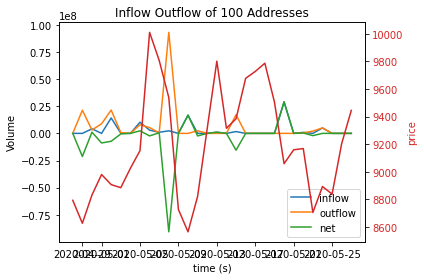

In [186]:
fig, ax1 = plt.subplots()

ax1.set_title(f"Inflow Outflow of {A} Addresses")
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Volume')
ax1.plot(gross_daily)
ax1.tick_params(axis='y')
ax1.legend(["inflow", "outflow", "net"], loc=4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel("price", color=color)  # we already handled the x-label with ax1
ax2.plot(ohlcv.close, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# Analysis
Looking for a relationship between Inflow/Outflow and Price

In [160]:
from scipy.stats.stats import pearsonr

print(pearsonr(ohlcv.close, gross_daily.net))

(-0.14694072792975102, 0.4384287447765489)
